In [62]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.cluster import hierarchy
import matplotlib

In [39]:
MTsat, R1, MD, R2, MTV, R2s = 0, 1, 2, 3, 4, 5
ANALYSE_BY_AREAS = True
ANALYSE_BY_SCANS = False


In [40]:
def D_kl(p1, p2):
    """
    calculate D_kl between two matrixes
    :param p1 first matrix
    :param p2 second mstrix
    :return:
    """
    C1 = np.einsum('ij,ik->ijk', p1, 1 / p2)  ###is it the right way?
    C2 = np.log(C1)
    C2[p1 == 0, :] = 0
    return np.einsum('ij,ijk->jk', p1, C2)


def D_kl_vec(p_y_x_hat):
    """
    function to
    :param p_y_x_hat:
    :return:
    """
    Dkl_vals = []
    for idx in range(p_y_x_hat.shape[1]):
        p_mean = np.mean(p_y_x_hat, axis=1)
        p_cur = p_y_x_hat[:, idx]
        dkl = sum([p_cur[x] * np.log(p_cur[x] / p_mean[x]) if (p_cur[x] > 0) 
                   else 0 for x in range(p_y_x_hat.shape[0])])
        # dkl = -sum([p_mean[x]*np.log(p_cur[x]/p_mean[x]) if (p_mean[x] > 0 and p_cur[x] > 0) else 0 for x in range(33)])
        Dkl_vals.append(dkl)
    return Dkl_vals


def generate_beta(max_value = 10000, length = 800):
    """
    making vector of decreasing beta values.
    :param max_value: maximum beta value
    :param length: length of vector
    :return: vetor of beta's
    """
    beta_values = [max_value]
    for idx in range(length-1):
        beta_values.append(beta_values[-1]*0.99)
    return beta_values[::-1]


In [25]:
def load_data(path, contrast):
    x = loadmat(path)
    mean_values = {}
    subjects = {}
    region = {}

    with open('gender.txt') as f:
         gender = f.read().splitlines()
    with open('age.txt') as f:
         age = f.read().splitlines()
    with open('area_names1.txt') as f:
         area_names = f.read().splitlines()
    with open('area_names2.txt') as f:
         area_names = f.read().splitlines()
    with open('area_types.txt') as f:
         area_types = f.read().splitlines()

    subj_id = [str(x + 1) for x in range(45)]
    sub = np.array(list(zip(subj_id, age, gender)))

    for ix in range(6):
        subjects[ix] = sub.copy()
        mean_values[ix] = x['huji_data']['data'][0][0][:, :, ix]

        mean_values[ix] = np.delete(mean_values[ix], 29, 0)  # remove Left Accumbens
        mean_values[ix] = np.delete(mean_values[ix], 20, 0)  # remove Medulla
        mean_values[ix] = np.delete(mean_values[ix], 8, 0)  # remove Right Accumbens

        subjects[ix] = subjects[ix][~np.isnan(mean_values[ix].T).any(axis=1)]
        mean_values[ix] = (mean_values[ix].T[~np.isnan(mean_values[ix].T).any(axis=1)]).T

    del area_names[29]  # remove Left Accumbens
    del area_names[20]  # remove Medulla
    del area_names[8]  # remove Right Accumbens


    del area_types[29]  # remove Left Accumbens
    del area_types[20]  # remove Medulla
    del area_types[8]  # remove Right Accumbens
    region = {}
    
    for x, y in zip(area_names, area_types):
        region[x] = y
        
    return mean_values[contrast], subjects, region, area_names, area_types


In [43]:
class IB:
    def __init__(self, input_matrix, subjects, regions, area_names, area_types, analyse_by_areas, beta_values):
        self.beta_values = beta_values
        self.analyse_by_areas = analyse_by_areas
        self.region = regions
        self.subjects = subjects
        self.input_matrix = input_matrix
        self.p_y_x_hat = None
        self.p_x_given_x_hat = None
        self.clusters_matrix = []
        self.full_distances = []
        self.clus = []
        self.area_names = area_names
        self.area_types = area_types

    def IB_iter(self, p_x, p_y_x, p_x_hat_given_x, beta):
        
        p_x_hat = p_x_hat_given_x @ p_x
        p_x_given_x_hat = (p_x_hat_given_x * p_x).T / (p_x_hat)
        # p_x_given_x_hat[np.isnan(p_x_given_x_hat)] = 0
        p_y_x_hat = p_y_x @ p_x_given_x_hat
        not_norm = np.exp(-beta * D_kl(p_y_x, p_y_x_hat)) * p_x_hat
        not_norm = not_norm.T
        return not_norm / np.sum(not_norm, axis=0)

    def prepare_prob(self, input_matrix):
        p_y_x = input_matrix / np.sum(input_matrix, axis=0)

        x_dim = p_y_x.shape[1]
        p_x = np.ones(x_dim)
        p_x = p_x / np.sum(p_x)

        p_x_hat_given_x = np.eye(x_dim) + abs(np.random.normal(0, 0.02, (x_dim, x_dim)))
        p_x_hat_given_x = p_x_hat_given_x / np.sum(p_x_hat_given_x, axis=0)

        return p_y_x, p_x, p_x_hat_given_x

    def get_clusters(self):
        p_y_x, p_x, p_x_hat_given_x = self.prepare_prob(self.input_matrix)

        self.beta_values = self.beta_values[::-1]

        for beta in self.beta_values:
            err = 1
            # while err > 1e-7:
            while err > (1 / beta) / 10:
                prev_p = p_x_hat_given_x
                p_x_hat_given_x = self.IB_iter(p_x, p_y_x, p_x_hat_given_x, beta)
                err = np.sum(abs(prev_p - p_x_hat_given_x))

            p_x_hat = p_x_hat_given_x @ p_x
            print(p_x_hat)
            p_x_given_x_hat = (p_x_hat_given_x * p_x).T / (p_x_hat)

            p_y_x_hat = p_y_x @ p_x_given_x_hat
            self.full_distances.append(D_kl_vec(p_y_x_hat))
            # self.clus.append(np.linalg.matrix_rank(p_y_x_hat, tol = 1e-7))
            # print(beta, np.linalg.matrix_rank(p_y_x_hat, tol = 1e-7))
            self.clus.append(np.linalg.matrix_rank(p_y_x_hat, tol=(1 / beta) / 10))
            # print(beta, np.linalg.matrix_rank(p_y_x_hat, tol = (1/beta)/10))
            t, indices = np.unique(p_x_given_x_hat.round(decimals=int(np.ceil(np.log10(10 * beta)))), axis=1,
                                   return_inverse=True)
            self.clusters_matrix.append(indices)
            # print(beta)
        # print(self.clusters_matrix)
        self.p_y_x_hat = p_y_x_hat
        self.p_x_given_x_hat = p_x_given_x_hat

    def run_analysis(self):
        #contrast = type
        #analyse_areas- if False, analyse subjects (take transpose of the matrix)

        # input_matrix = np.exp(mean_values[contrast]**2)
        # input_matrix = np.exp(-1/mean_values[contrast])  ###for MTV
        # input_matrix = mean_values[contrast]**4  ###for R2s
        # input_matrix = np.exp(-1/mean_values[contrast]**2)  ###for MD

        if self.analyse_by_areas:
            self.input_matrix = self.input_matrix.T
        self.get_clusters()

        print("Done")

In [81]:
ib_data.clusters_matrix

[array([25, 10, 15, 21, 14,  5, 19,  1,  8,  6, 18, 23,  9,  9, 17, 17, 20,
        24, 13, 25, 11, 15, 21,  3,  4, 16,  2,  7,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 14,  5, 19,  1,  8,  6, 18, 22,  9,  9, 17, 17, 20,
        23, 13, 24, 11, 15, 21,  3,  4, 16,  2,  7,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 13,  5, 19,  1,  8,  6, 18, 22,  9,  9, 17, 17, 20,
        23, 14, 24, 11, 15, 21,  3,  4, 16,  2,  7,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 14,  4, 19,  1,  7,  5, 18, 22,  9,  9, 17, 17, 20,
        23, 13, 24, 11, 15, 21,  8,  3, 16,  2,  6,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 14,  4, 19,  1,  7,  5, 18, 22,  9,  9, 17, 17, 20,
        23, 13, 24, 11, 15, 21,  8,  3, 16,  2,  6,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 14,  4, 19,  1,  7,  5, 18, 22,  9,  9, 17, 17, 20,
        23, 13, 24, 11, 15, 21,  8,  3, 16,  2,  6,  0, 12, 22,  9,  9, 17,
        17]),
 arr

In [51]:
ib_data = IB(*load_data("/ems/elsc-labs/mezer-a/nitai.seri/Desktop/IB-for-MRI/huji_data.mat", MTV), ANALYSE_BY_AREAS, generate_beta())

In [52]:
ib_data.run_analysis()

[0.02894893 0.02788865 0.03095126 0.0294887  0.02862227 0.02776628
 0.02785342 0.02857191 0.02857628 0.02856317 0.02829006 0.02956631
 0.02409492 0.03967066 0.03018475 0.03408871 0.01636392 0.02713743
 0.02849915 0.02948143 0.02839952 0.0272957  0.02793457 0.02858173
 0.02849439 0.02860896 0.02856803 0.02858507 0.02855694 0.02838174
 0.0282955  0.02341205 0.0280484  0.02327665 0.03895253]
[0.02899318 0.02789934 0.0309523  0.02949193 0.02862585 0.02771513
 0.02780749 0.02857194 0.02857605 0.02856265 0.02826237 0.02959132
 0.0240535  0.03960246 0.03047197 0.03441308 0.0154291  0.02705607
 0.02849237 0.0295265  0.02840444 0.02729662 0.02793763 0.02858353
 0.02848683 0.02861284 0.02856768 0.02858646 0.02855567 0.02836098
 0.02831942 0.0233718  0.02800018 0.02349815 0.03932318]
[0.02904134 0.02792046 0.03094773 0.02949493 0.02862966 0.02766083
 0.02775869 0.02857198 0.02857577 0.02856207 0.02823213 0.02961807
 0.02400319 0.03951963 0.03079397 0.03477672 0.01439513 0.02697009
 0.02848501 0.0

[3.19614641e-02 2.89198593e-02 3.06863908e-02 2.91993619e-02
 2.87242523e-02 2.59570943e-02 2.59234994e-02 2.85729278e-02
 2.85394841e-02 2.85350584e-02 2.65873319e-02 3.06675230e-02
 2.25025799e-02 3.70489755e-02 3.63506014e-02 4.10520223e-02
 1.48689933e-06 2.44263073e-02 2.80935785e-02 3.25493864e-02
 2.83033674e-02 2.70621125e-02 2.76604805e-02 2.86975339e-02
 2.81324470e-02 2.87201914e-02 2.85494680e-02 2.86558876e-02
 2.84935235e-02 2.70760433e-02 2.93493715e-02 2.18648347e-02
 2.61947867e-02 2.80313899e-02 4.69093766e-02]
[3.25642879e-02 2.89154477e-02 3.06863244e-02 2.89991118e-02
 2.87252047e-02 2.58105554e-02 2.56660954e-02 2.85729914e-02
 2.85338162e-02 2.85315882e-02 2.63163980e-02 3.07393477e-02
 2.24171031e-02 3.69082436e-02 3.64535600e-02 4.11682970e-02
 1.49111079e-06 2.44163033e-02 2.80391586e-02 3.31632990e-02
 2.82990499e-02 2.70620539e-02 2.74707842e-02 2.87157040e-02
 2.80972549e-02 2.86905559e-02 2.85474769e-02 2.86636485e-02
 2.84866264e-02 2.68900197e-02 2.94181

[2.63187146e-02 3.06026295e-02 2.66860872e-02 3.03388383e-03
 2.73715775e-02 2.25416939e-02 1.38197478e-01 2.85738271e-02
 2.83025152e-02 2.83735982e-02 1.23537109e-02 7.62152181e-03
 1.48236569e-02 2.44061484e-02 4.55423376e-02 5.14325757e-02
 1.86288173e-06 5.90483830e-02 2.59440162e-02 2.68028401e-02
 2.99502656e-02 2.35342728e-02 2.87399036e-03 2.95339335e-02
 2.72111256e-02 1.84088432e-02 2.85031803e-02 2.89201029e-02
 2.82524948e-02 2.19888050e-02 7.29393355e-03 1.44035399e-02
 1.72559117e-02 3.51195019e-02 5.87710403e-02]
[2.49806003e-02 3.15415527e-02 2.55033222e-02 1.20391934e-03
 2.73433806e-02 2.22317953e-02 1.49071022e-01 2.85738827e-02
 2.82700432e-02 2.83578879e-02 1.12842016e-02 8.22119230e-03
 1.48578103e-02 2.44623797e-02 4.56472662e-02 5.15510753e-02
 1.86717377e-06 5.60462041e-02 2.57452457e-02 2.54401116e-02
 3.08691736e-02 2.24912007e-02 1.14046970e-03 2.95035090e-02
 2.71283985e-02 1.75055006e-02 2.84995426e-02 2.89538436e-02
 2.82244011e-02 2.16421136e-02 7.86782

[1.29874698e-02 3.14264577e-02 2.08887151e-02 1.00813183e-08
 2.64607389e-02 1.49570937e-02 2.45951427e-01 2.85753154e-02
 2.69404963e-02 2.78959273e-02 7.13538330e-10 1.35640982e-02
 1.56877906e-02 2.58288863e-02 4.81971937e-02 5.44307985e-02
 1.97147700e-06 2.91385466e-02 2.14912448e-02 1.32263708e-02
 3.07565320e-02 1.84216111e-02 9.55000692e-09 2.85511386e-02
 2.51593837e-02 1.73218824e-05 2.84337110e-02 3.03287370e-02
 2.73752198e-02 7.45586146e-03 1.29810861e-02 1.52431833e-02
 1.82618318e-02 3.71667667e-02 6.21970533e-02]
[1.31120661e-02 3.11782154e-02 2.07237120e-02 1.01780342e-08
 2.64197947e-02 1.42180774e-02 2.48310981e-01 2.85754193e-02
 2.67194043e-02 2.78436067e-02 7.20383717e-10 1.36942264e-02
 1.57679752e-02 2.59609048e-02 4.84435427e-02 5.47090091e-02
 1.98155375e-06 2.94180895e-02 2.10858325e-02 1.33532590e-02
 3.05135815e-02 1.82760960e-02 9.64162567e-09 2.85069598e-02
 2.49660202e-02 1.22657355e-05 2.84285249e-02 3.05529819e-02
 2.72743235e-02 5.27954312e-03 1.31056

[1.44523556e-02 2.64046612e-02 1.75507991e-02 1.12184127e-08
 2.32572895e-02 1.77178871e-07 2.73692837e-01 2.85743105e-02
 1.35238995e-02 2.63553549e-02 7.94019912e-10 1.50940231e-02
 1.72995213e-02 2.84824920e-02 5.31488724e-02 6.00229047e-02
 2.17402241e-06 3.24251483e-02 1.04404815e-02 1.47182027e-02
 2.58417864e-02 1.54779264e-02 1.06271735e-08 2.50946165e-02
 1.98624148e-02 2.13818160e-08 2.83605061e-02 4.47932382e-02
 2.41500073e-02 9.20337955e-06 1.44452518e-02 1.68092360e-02
 2.01380141e-02 4.09852024e-02 6.85870482e-02]
[1.45529502e-02 2.60100171e-02 1.72884848e-02 1.12964977e-08
 2.29837412e-02 1.51075696e-08 2.75597858e-01 2.85742132e-02
 1.35940060e-02 2.60591061e-02 7.99546634e-10 1.51990840e-02
 1.73667145e-02 2.85931210e-02 5.33553082e-02 6.02560400e-02
 2.18246655e-06 3.26508414e-02 9.45793439e-03 1.48206477e-02
 2.54555550e-02 1.52465933e-02 1.07011433e-08 2.47994579e-02
 1.92841782e-02 2.15306427e-08 2.83594532e-02 4.50254413e-02
 2.38233490e-02 9.26743906e-06 1.45457

[1.62004667e-02 1.79460517e-02 1.19284828e-02 1.25753563e-08
 1.78902447e-02 1.90062043e-10 3.06797855e-01 2.85722339e-02
 1.84010834e-02 1.19957265e-02 8.90062044e-10 1.69197483e-02
 1.87315616e-02 3.08402494e-02 5.75484925e-02 6.49915516e-02
 2.35398621e-06 3.63471915e-02 6.20912650e-36 1.64984698e-02
 1.75634912e-02 1.05196452e-02 1.19126028e-08 1.93035750e-02
 6.48211495e-03 2.39680927e-08 2.84943193e-02 6.09472218e-02
 1.02267342e-02 1.03165912e-05 1.61925036e-02 1.82006908e-02
 2.18050225e-02 4.43779239e-02 7.42646279e-02]
[1.63275687e-02 1.71594926e-02 1.14056683e-02 1.26740172e-08
 1.74829716e-02 1.91223161e-10 3.09204861e-01 2.85718338e-02
 1.93827305e-02 9.43041745e-03 8.97045093e-10 1.70524935e-02
 1.88459956e-02 3.10286572e-02 5.79000651e-02 6.53885950e-02
 2.36836708e-06 3.66323561e-02 6.25784067e-36 1.66279098e-02
 1.67936994e-02 1.00585787e-02 1.20060640e-08 1.88641272e-02
 5.26224072e-03 2.41561362e-08 2.85198439e-02 6.41985882e-02
 7.91147504e-03 1.03975308e-05 1.63195

[1.94312989e-02 1.48509424e-05 9.87120814e-06 1.50832387e-08
 9.05703757e-03 2.00345181e-10 3.67982042e-01 2.85141595e-02
 1.90430783e-02 1.45576960e-03 1.06756564e-09 2.02940256e-02
 1.97450160e-02 3.25088336e-02 6.06621025e-02 6.85078616e-02
 2.48134654e-06 4.35958515e-02 7.44740229e-36 1.97887322e-02
 1.45343612e-05 8.70534910e-06 1.42883133e-08 9.77254399e-03
 2.05394773e-31 2.87480097e-08 2.97544720e-02 6.30736079e-02
 9.71544389e-05 1.23740118e-05 1.94217477e-02 1.91854230e-02
 2.29847638e-02 4.67789520e-02 7.82826495e-02]
[1.95162855e-02 1.49158960e-05 9.91438183e-06 1.51492083e-08
 8.44841857e-03 2.00444200e-10 3.69591484e-01 2.85028464e-02
 1.87713069e-02 1.43499372e-03 1.07223485e-09 2.03827855e-02
 1.97547749e-02 3.25249009e-02 6.06920843e-02 6.85417212e-02
 2.48257293e-06 4.37865266e-02 7.47997497e-36 1.98752822e-02
 1.45979301e-05 8.74342367e-06 1.43508061e-08 9.11584405e-03
 2.05496288e-31 2.88737447e-08 2.99072423e-02 6.21734591e-02
 9.57679088e-05 1.24281320e-05 1.95066

[2.09859525e-02 1.60391323e-05 1.06609809e-05 1.62900141e-08
 1.38445506e-07 2.01521631e-10 3.97423441e-01 2.79305433e-02
 1.32598707e-02 1.01366577e-03 1.15297912e-09 2.19177040e-02
 1.98609611e-02 3.26997293e-02 6.10183175e-02 6.89101479e-02
 2.49591730e-06 4.70838555e-02 8.04325185e-36 2.13719833e-02
 1.56972221e-05 9.40184411e-06 1.54314885e-08 1.49382708e-07
 2.06600876e-31 3.10480719e-08 3.32800040e-02 4.39187337e-02
 6.76495300e-05 1.33640281e-05 2.09756372e-02 1.92980820e-02
 2.31197331e-02 4.70536435e-02 7.87423344e-02]
[2.10630024e-02 1.60980199e-05 1.07001227e-05 1.63498228e-08
 8.56965202e-09 2.01636593e-10 3.98882581e-01 2.78697503e-02
 1.27720556e-02 9.76374193e-04 1.15721228e-09 2.19981749e-02
 1.98722911e-02 3.27183834e-02 6.10531264e-02 6.89494588e-02
 2.49734113e-06 4.72567239e-02 8.07278265e-36 2.14504505e-02
 1.57548544e-05 9.43636298e-06 1.54881452e-08 9.24665495e-09
 2.06718734e-31 3.11620649e-08 3.33390676e-02 4.23030150e-02
 6.51607831e-05 1.34130941e-05 2.10526

[2.27254388e-02 1.73685859e-05 1.15446496e-05 1.76402628e-08
 4.12049422e-28 2.03961340e-10 4.30365125e-01 2.47794988e-02
 2.40064484e-03 1.83520002e-04 1.24854740e-09 2.37344215e-02
 2.01014065e-02 3.30956065e-02 6.17570318e-02 6.97444041e-02
 2.52613396e-06 5.09865482e-02 8.70994193e-36 2.31434670e-02
 1.69983354e-05 1.01811454e-05 1.67105757e-08 4.44601347e-28
 2.09102076e-31 3.36215885e-08 3.59816428e-02 7.95130540e-03
 1.22476681e-05 1.44717474e-05 2.27142685e-02 1.95317130e-02
 2.33996306e-02 4.76232954e-02 7.96956233e-02]
[2.28857615e-02 1.74911172e-05 1.16260944e-05 1.77647108e-08
 4.22336921e-28 2.04183014e-10 4.33401252e-01 2.38133439e-02
 1.40704867e-03 1.07563422e-04 1.25735561e-09 2.39018623e-02
 2.01232536e-02 3.31315762e-02 6.18241521e-02 6.98202054e-02
 2.52887947e-06 5.13462464e-02 8.77138855e-36 2.33067388e-02
 1.71182547e-05 1.02529710e-05 1.68284649e-08 4.55701559e-28
 2.09329337e-31 3.38587810e-08 3.68799843e-02 4.66036186e-03
 7.17851501e-06 1.45738422e-05 2.28745

[2.36240925e-02 1.80554085e-05 1.20011707e-05 1.83378286e-08
 4.30047979e-28 1.98444918e-10 4.47383465e-01 2.06675528e-02
 4.00202189e-08 3.05939077e-09 1.29791990e-09 2.46729744e-02
 1.95577356e-02 3.22004891e-02 6.00867258e-02 6.78580684e-02
 2.45781110e-06 5.30027580e-02 9.05436750e-36 2.40586512e-02
 1.76705168e-05 1.05837481e-05 1.73713780e-08 4.64021791e-28
 2.03446615e-31 3.49511191e-08 3.75533417e-02 1.32553128e-07
 2.04176124e-10 1.50440175e-05 2.36124805e-02 1.90034503e-02
 2.27667546e-02 4.63352563e-02 7.75401429e-02]
[2.36811669e-02 1.80990292e-05 1.20301648e-05 1.83821317e-08
 4.28546738e-28 1.97733718e-10 4.48464316e-01 2.05954051e-02
 4.01169053e-08 3.06678207e-09 1.30105559e-09 2.47325828e-02
 1.94876434e-02 3.20850869e-02 5.98713831e-02 6.76148742e-02
 2.44900264e-06 5.31308094e-02 9.07624229e-36 2.41167754e-02
 1.77132077e-05 1.06093178e-05 1.74133461e-08 4.62401951e-28
 2.02717490e-31 3.50355588e-08 3.74222479e-02 1.32873368e-07
 2.04669401e-10 1.50803629e-05 2.36695

[2.55768745e-02 1.95478796e-05 1.29931949e-05 1.98536448e-08
 4.00221283e-28 1.72435930e-10 4.84364457e-01 1.92341201e-02
 4.33283148e-08 3.31228189e-09 1.40520676e-09 2.67124576e-02
 1.69944203e-02 2.79801637e-02 5.22115183e-02 5.89643175e-02
 2.13568051e-06 5.73839985e-02 9.80280707e-36 2.60473541e-02
 1.91311726e-05 1.14586073e-05 1.88073067e-08 4.31838784e-28
 1.76782085e-31 3.78402001e-08 3.49487669e-02 1.43510051e-07
 2.21053448e-10 1.62875652e-05 2.55643027e-02 1.65127818e-02
 1.97828523e-02 4.02623715e-02 6.73774204e-02]
[2.58612463e-02 1.97652192e-05 1.31376573e-05 2.00743839e-08
 3.97958095e-28 1.68486567e-10 4.89749774e-01 1.91253542e-02
 4.38100527e-08 3.34910888e-09 1.42083029e-09 2.70094552e-02
 1.66051908e-02 2.73393238e-02 5.10156987e-02 5.76138361e-02
 2.08676624e-06 5.80220120e-02 9.91179778e-36 2.63369568e-02
 1.93438790e-05 1.15860077e-05 1.90164123e-08 4.29396804e-28
 1.72733180e-31 3.82609194e-08 3.47511372e-02 1.45105641e-07
 2.23511190e-10 1.64686555e-05 2.58485

[3.42034197e-02 2.61409709e-05 1.73755279e-05 2.65498642e-08
 3.39359433e-28 5.20239874e-11 6.47730464e-01 1.63091779e-02
 5.79420497e-08 4.42944534e-09 1.87915362e-09 3.57220112e-02
 5.12722323e-03 8.44162632e-03 1.57522354e-02 1.77895576e-02
 6.44335644e-07 7.67384218e-02 1.31090890e-35 3.48325822e-02
 2.55837173e-05 1.53233560e-05 2.51506182e-08 3.66168845e-28
 5.33352240e-32 5.06029086e-08 2.96340905e-02 1.91912992e-07
 2.95610155e-10 2.17810205e-05 3.41866076e-02 4.98191272e-03
 5.96849427e-03 1.21471732e-02 2.03277940e-02]
[3.42323516e-02 2.61630829e-05 1.73902254e-05 2.65723221e-08
 3.33398447e-28 5.20679925e-11 6.48278364e-01 1.60227006e-02
 5.79910615e-08 4.43319210e-09 1.88074315e-09 3.57522276e-02
 5.13156014e-03 8.44876676e-03 1.57655596e-02 1.78046051e-02
 6.44880662e-07 7.68033330e-02 1.31201777e-35 3.48620462e-02
 2.56053579e-05 1.53363176e-05 2.51718925e-08 3.59736941e-28
 5.33803382e-32 5.06457124e-08 2.91135558e-02 1.92075326e-07
 2.95860204e-10 2.17994446e-05 3.42155

[3.49216772e-02 2.66899203e-05 1.77404067e-05 2.71074002e-08
 1.91372683e-28 5.31164681e-11 6.61332533e-01 9.19712504e-03
 5.91588085e-08 4.52246183e-09 1.91861506e-09 3.64721585e-02
 5.23489265e-03 8.61889674e-03 1.60830254e-02 1.81631304e-02
 6.57866408e-07 7.83498965e-02 1.33843744e-35 3.55640518e-02
 2.61209646e-05 1.56451400e-05 2.56787706e-08 2.06491135e-28
 5.44552401e-32 5.16655485e-08 1.67113535e-02 1.95943084e-07
 3.01817845e-10 2.22384129e-05 3.49045121e-02 5.08653068e-03
 6.09383001e-03 1.24022585e-02 2.07546687e-02]
[3.49761689e-02 2.67315672e-05 1.77680888e-05 2.71496985e-08
 1.80145455e-28 5.31993509e-11 6.62364474e-01 8.65755887e-03
 5.92511197e-08 4.52951866e-09 1.92160886e-09 3.65290695e-02
 5.24306115e-03 8.63234563e-03 1.61081213e-02 1.81914721e-02
 6.58892940e-07 7.84721534e-02 1.34052593e-35 3.56195458e-02
 2.61617237e-05 1.56695527e-05 2.57188397e-08 1.94376955e-28
 5.45402119e-32 5.17461672e-08 1.57309513e-02 1.96248833e-07
 3.02288800e-10 2.22731136e-05 3.49589

[3.58504389e-02 2.73997538e-05 1.82122228e-05 2.78283368e-08
 1.45143476e-32 5.45291306e-11 6.78921045e-01 6.97540877e-07
 6.07321704e-08 4.64273926e-09 1.96964171e-09 3.74421561e-02
 5.37411757e-03 8.84812116e-03 1.65107625e-02 1.86461891e-02
 6.75362736e-07 8.04336562e-02 1.37403394e-35 3.65098979e-02
 2.68156664e-05 1.60612314e-05 2.63617120e-08 1.56609817e-32
 5.59035080e-32 5.30396229e-08 1.26744522e-06 2.01154301e-07
 3.09844860e-10 2.28298560e-05 3.58328173e-02 5.22180983e-03
 6.25589885e-03 1.27321035e-02 2.13066508e-02]
[3.58504493e-02 2.73997617e-05 1.82122281e-05 2.78283449e-08
 1.23736818e-32 5.45291464e-11 6.78921242e-01 5.94663233e-07
 6.07321880e-08 4.64274060e-09 1.96964228e-09 3.74421670e-02
 5.37411913e-03 8.84812372e-03 1.65107673e-02 1.86461945e-02
 6.75362932e-07 8.04336795e-02 1.37403434e-35 3.65099084e-02
 2.68156742e-05 1.60612360e-05 2.63617197e-08 1.33512033e-32
 5.59035242e-32 5.30396383e-08 1.08051455e-06 2.01154359e-07
 3.09844950e-10 2.28298626e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.0115

 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.0115

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328424e-02 5.22181349e-03
 6.25590324e-03 1.27321124e-02 2.13066658e-02]
[3.58504640e-02 2.73997730e-05 1.82122356e-05 2.78283563e-08
 9.33981328e-33 5.45291688e-11 6.78921521e-01 4.48859414e-07
 6.07322130e-08 4.64274251e-09 1.96964309e-09 3.74421824e-02
 5.37412133e-03 8.84812736e-03 1.65107741e-02 1.86462022e-02
 6.75363209e-07 8.04337126e-02 1.37403490e-35 3.65099234e-02
 2.68156852e-05 1.60612426e-05 2.63617305e-08 1.00776590e-32
 5.59035471e-32 5.30396601e-08 8.15586206e-07 2.01154442e-07
 3.09845077e-10 2.28298720e-05 3.58328

Done


In [69]:
## Plot results:
def subj_to_text(subj):
    #return 'ID: ' + subj[0] + ' Age: ' + subj[1] + ' ' + subj[2]
    return 'Age: ' + str(subj[1]) + ' (' + str(subj[2]) + ')'


def plot_results(ib_d):
    #plot_axis = [1, max(beta_values), 0,max(max(full_distances))*1.10]
    plot_axis = [200, 6000, 0,0.005]
    #plot_axis = [1000, 5000, 0,0.015]

    # plot bifrucation diagram:
    plt.figure(figsize=(30,30))
    plt.rcParams["figure.figsize"]=30,30
    fd = np.array(ib_d.full_distances)

    ## separate white:
    #for idx in range(fd.shape[1]):
        #if 'wm' in area_names[idx] or 'White' in area_names[idx] or area_names[idx] == 'CC':
        #if 'ctx' in area_names[idx]:
    #        fd[:500,idx] = -fd[:500,idx]
    for idx in range(fd.shape[1]):
        plt.plot(ib_d.beta_values,fd[:,idx],linewidth=3)

    #plot legend
    for idx in range(ib_d.p_y_x_hat.shape[1]):
        text_condition = fd[0,idx] < plot_axis[3]
        text_condition = True
        if not(fd[0,idx] == np.inf):
            if text_condition:
                if ib_d.analyse_by_areas:
                    plt.text(plot_axis[1]*1.05, fd[0,idx],ib_d.area_names[idx],fontsize=20) #,rotation=45,rotation_mode = "anchor")
                else:
                    plt.text(plot_axis[1]*1.05, fd[0,idx],subj_to_text(ib_d.subjects[idx]),fontsize=20) #,rotation=45,rotation_mode = "anchor")

    plt.title('R2s')
    plt.xscale("log")
    plt.xlabel('beta')
    plt.ylabel('Dkl to mean', fontsize=20)
    plt.axis(plot_axis)
    plt.savefig('/ems/elsc-labs/mezer-a/nitai.seri/Desktop/IB-for-MRI/MTV.png')

35


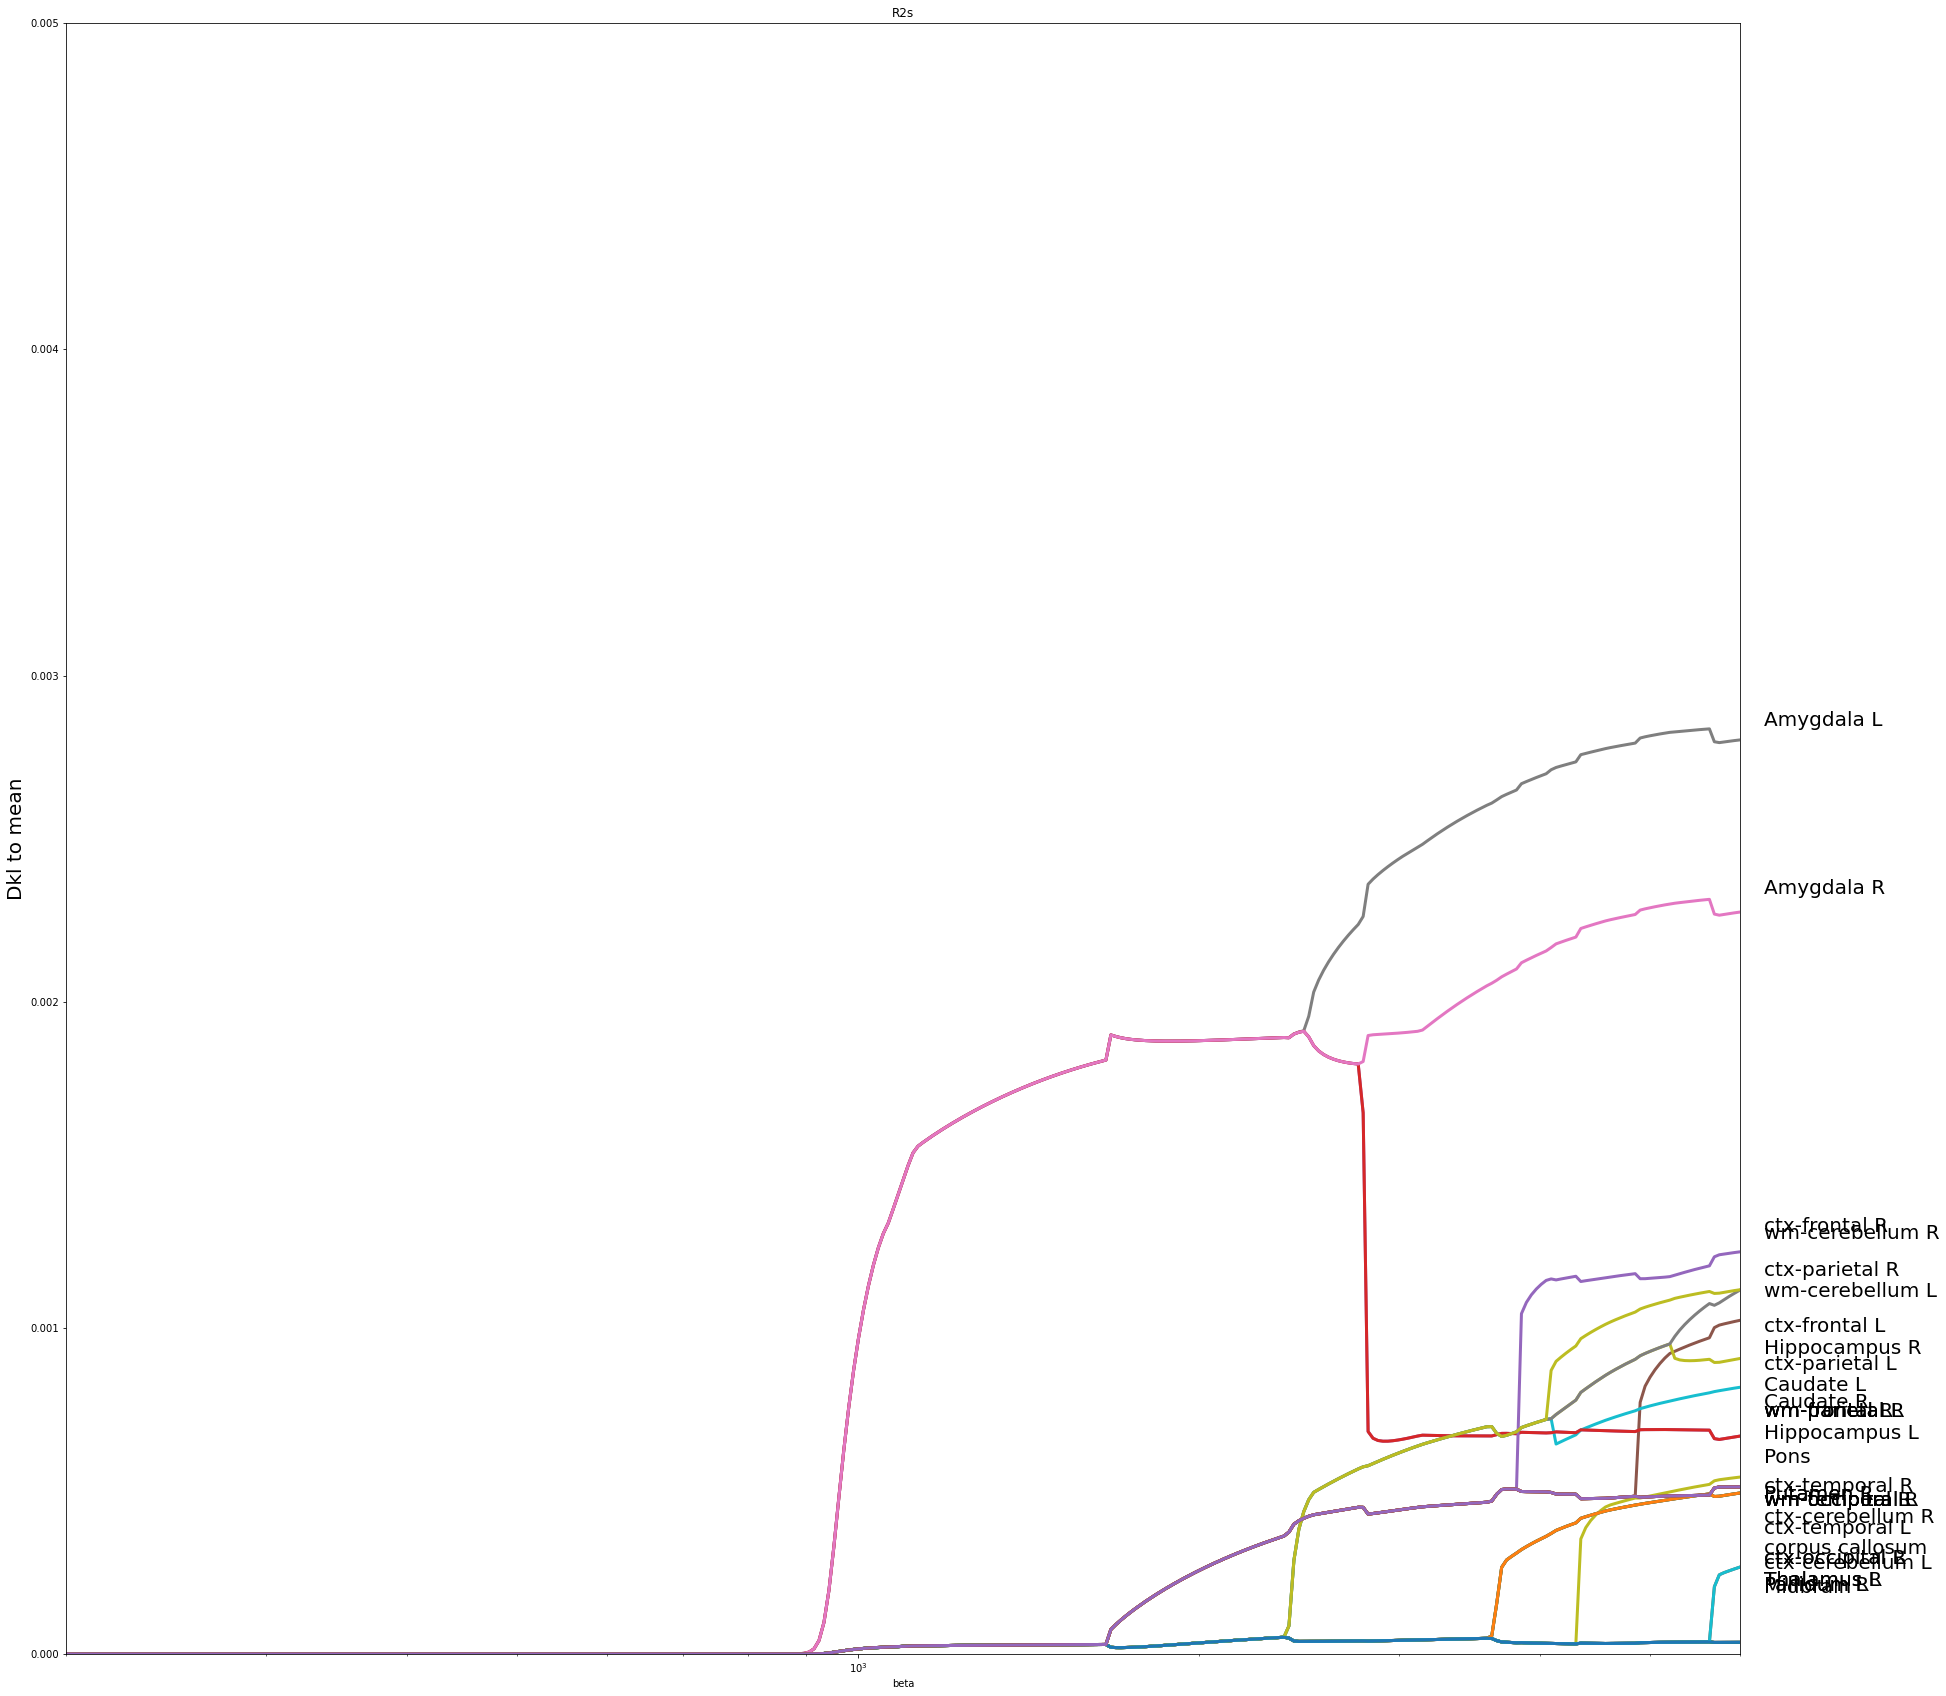

In [70]:
plot_results(ib_data)

In [60]:
def find_multi(tt,x):
    return [i for i, y in enumerate(tt) if y == x]

tt = np.array(ib_data.clusters_matrix)
num = tt.shape[1]
idx_lst = list(range(num))
cntr = num
Z = []
running_idx = 1

def clus_iter(tt,cntr,idx_lst,iter_num,Z,running_idx):
    pp = list(tt[iter_num,:])
    for x in set(pp):
        if list(pp).count(x) > 1 and x != -1:
            idxs = find_multi(pp,x)
            if len(idxs) > 2:
                print('oops', idxs)
            tt[:,idxs[0]] = -1
            print('merge ' + str(idx_lst[idxs[1]]) + ' and ' + str(idx_lst[idxs[0]]) + ' into ' + str(cntr))
            Z.append([idx_lst[idxs[1]], idx_lst[idxs[0]], iter_num, running_idx])
            idx_lst[idxs[1]] = cntr
            idx_lst[idxs[0]] = cntr
            cntr += 1
            running_idx += 1
    
    return tt,cntr,idx_lst,Z,running_idx
    
    
#print(tt.shape[0])

#for idx in range(-1,-tt.shape[0]-1,-1):
for idx in range(tt.shape[0]):
    tt,cntr,idx_lst,Z,running_idx = clus_iter(tt,cntr,idx_lst,idx,Z,running_idx)

Z = np.array(Z,dtype = 'double')
#print(tt[-16,:])
#print(tt[-20,:])
#print(idx_lst)

#print(area_names[19])
print(Z)
Z[:,2] = Z[:,2]-min(Z[:,2])

for i in range(Z.shape[0]):
    Z[i,2] = i*5
    #if Z[i,0] > 27:
    #    Z[i,0] = Z[i,0] - 1
    #if Z[i,1] > 27:
    #    Z[i,1] = Z[i,1] - 1
        
#Z = Z[:-1,:]
#print(Z)

[[25 10 15 ...  9 17 17]
 [24 10 15 ...  9 17 17]
 [24 10 15 ...  9 17 17]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
35
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
oops [12, 13, 31, 32]
merge 13 and 12 into 35
merge 21 and 2 into 36
oops [14, 15, 33, 34]
merge 15 and 14 into 37
merge 22 and 3 into 38
merge 19 and 0 into 39
oops [13, 31, 32]
merge 31 and 35 into 40
oops [15, 33, 34]
merge 33 and 37 into 41
merge 30 and 11 into 42
merge 32 and 40 into 43
merge 34 and 41 into 44
merge 20 and 1 into 45
merge 44 and 16 into 46
merge 23 and 4 into 47
merge 39 and 17 into 48
merge 42 and 6 into 49
merge 46 and 43 into 50
merge 36 and 45 into 51
merge 38 and 48 into 52
merge 49 and 52 into 53
merge 53 and 10 into 54
merge 29 and 25 into 55
merge 54 and 55 into 56
merge 27 and 8 into 57
merge 50 and 5 into 58
merge 56 and 18 into 59
merge 57 and 9 into 60
merge 28 and 60

In [55]:
ib_data.clusters_matrix

[array([25, 10, 15, 21, 14,  5, 19,  1,  8,  6, 18, 23,  9,  9, 17, 17, 20,
        24, 13, 25, 11, 15, 21,  3,  4, 16,  2,  7,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 14,  5, 19,  1,  8,  6, 18, 22,  9,  9, 17, 17, 20,
        23, 13, 24, 11, 15, 21,  3,  4, 16,  2,  7,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 13,  5, 19,  1,  8,  6, 18, 22,  9,  9, 17, 17, 20,
        23, 14, 24, 11, 15, 21,  3,  4, 16,  2,  7,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 14,  4, 19,  1,  7,  5, 18, 22,  9,  9, 17, 17, 20,
        23, 13, 24, 11, 15, 21,  8,  3, 16,  2,  6,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 14,  4, 19,  1,  7,  5, 18, 22,  9,  9, 17, 17, 20,
        23, 13, 24, 11, 15, 21,  8,  3, 16,  2,  6,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 14,  4, 19,  1,  7,  5, 18, 22,  9,  9, 17, 17, 20,
        23, 13, 24, 11, 15, 21,  8,  3, 16,  2,  6,  0, 12, 22,  9,  9, 17,
        17]),
 arr

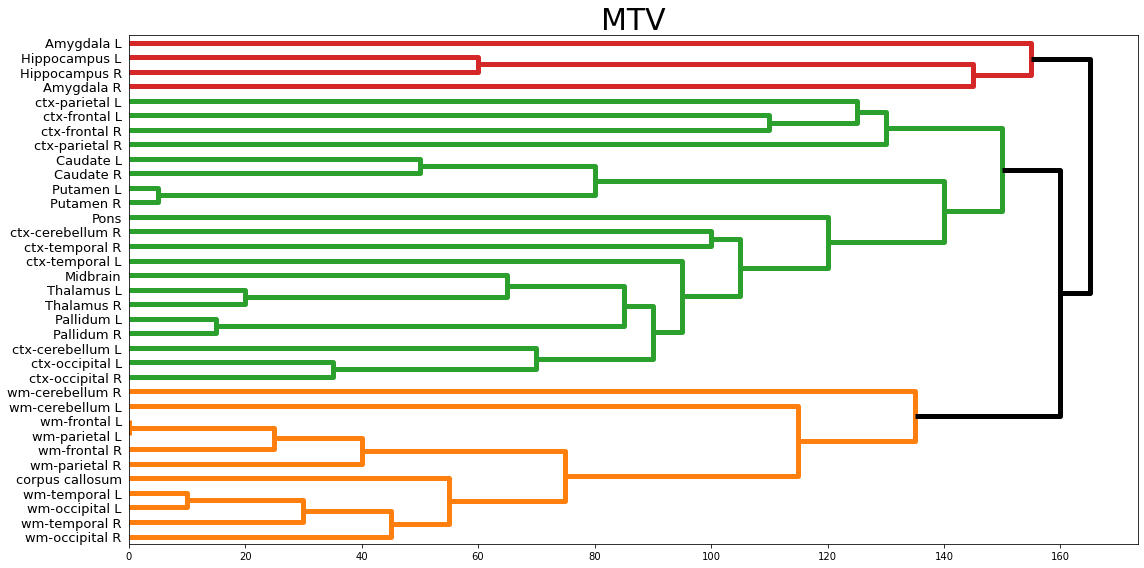

In [63]:
# Override the default linewidth.
matplotlib.rcParams['lines.linewidth'] = 5

fig, ax = plt.subplots(1,1)
ax.set_title('MTV', fontsize=30)
fig.set_size_inches(16,8)
#dn = hierarchy.dendrogram(Z,labels=area_names,leaf_rotation=-80, ax=ax)
if ib_data.analyse_by_areas:
    dn = hierarchy.dendrogram(Z,labels=ib_data.area_names, ax=ax, orientation = 'right',color_threshold = 160,above_threshold_color='k')
    #dn = hierarchy.dendrogram(Z,labels=area_names, ax=ax, color_threshold = 160,above_threshold_color='k',leaf_rotation=-80)
else:
    #dn = hierarchy.dendrogram(Z,labels=[subj_to_text(x) for x in subjects[contrast]],orientation = 'right',leaf_rotation=-80, ax=ax)
    dn = hierarchy.dendrogram(Z,labels=[subj_to_text(x) for x in ib_data.subjects[contrast]],
                              ax=ax,leaf_rotation=-80,color_threshold = 205, above_threshold_color='k')
    #dn = hierarchy.dendrogram(Z,labels=[subj_to_text(x) for x in subjects[contrast]],
    #                          ax=ax,color_threshold = 300, above_threshold_color='k',orientation = 'right')
#dn = hierarchy.dendrogram(Z,labels=area_names, ax=ax)
#dn = hierarchy.dendrogram(Z,leaf_rotation=-80, ax=ax)
#ax.tick_params(axis='x',which = 'major', labelsize=15)
ax.tick_params(axis='y',which = 'major', labelsize=13)
plt.tight_layout()

#hierarchy.set_link_color_palette(['#045a8d', '#2b8cbe', '#74a9cf', '#a6bddb'])
#hierarchy.set_link_color_palette(['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462'][::-1])
#hierarchy.set_link_color_palette(['#66c2a5','#fc8d62','#8da0cb','#e78ac3'][::-1])
#hierarchy.set_link_color_palette(['#993404','#406020','#fd8d3c','#732673'][::-1])
hierarchy.set_link_color_palette(['#993404','#64ad30','#a2142e','#7e2f8e'][::-1])
#bordo: a2142e
#orange: d95319
#yellow: eeb220


#region_color = {'other':'k','bg':'y','limbic':'b','ctx':'r','wm':'g'}
#region_color = {'other':'k','bg':'#1f78b4','limbic':'k','ctx':'#e31a1c','wm':'#33a02c'}
region_color = {'other':'#aaaaaa','bg':'#aaaaaa','limbic':'#aaaaaa','ctx':'#636363','wm':'k'}

# if analyse_areas:
#     for ticklabel in plt.gca().get_yticklabels():
#         ticklabel.set_color(region_color[region[ticklabel.get_text()]])
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False)
#     plt.xlabel('Clustering level')
# else:
#     for ticklabel in plt.gca().get_yticklabels():
#         if int(subjects[contrast][int(ticklabel.get_text())][1])>50:
#         #if int(ticklabel.get_text()[5:7])>50:
#             ticklabel.set_color('#636363')
#         else:
#             ticklabel.set_color('k')
#             ticklabel.set_fontweight('bold')

    
#hierarchy.set_link_color_palette(None)
#print([subj_to_text(x) for x in subjects[contrast]])
#plt.savefig('C:\\Users\\Yoav\\Desktop\\ELSC\\Aviv\\Tali\\IB\\MTV_for_grant4.png')
#plt.savefig('C:\\Users\\Yoav\\Desktop\\ELSC\\Aviv\\Tali\\grant\\MTV_areas4.png')
# plt.savefig('D:\\ELSC\\Aviv\\Tali\\grant\\new_MTV_6.png')

[6 5 5 6 3 4 6 0 2 2 6 6 4 4 4 4 4 6 6 6 5 5 6 3 4 6 1 2 2 6 6 4 4 4 4]
(45, 35)
ShapiroResult(statistic=0.9309542179107666, pvalue=2.3247735499095084e-26)
0 Thalamus L
3 Pallidum L
6 ctx-cerebellum L
10 ctx-temporal L
11 ctx-occipital L
17 Midbrain
18 Pons
19 Thalamus R
22 Pallidum R
25 ctx-cerebellum R
29 ctx-temporal R
30 ctx-occipital R


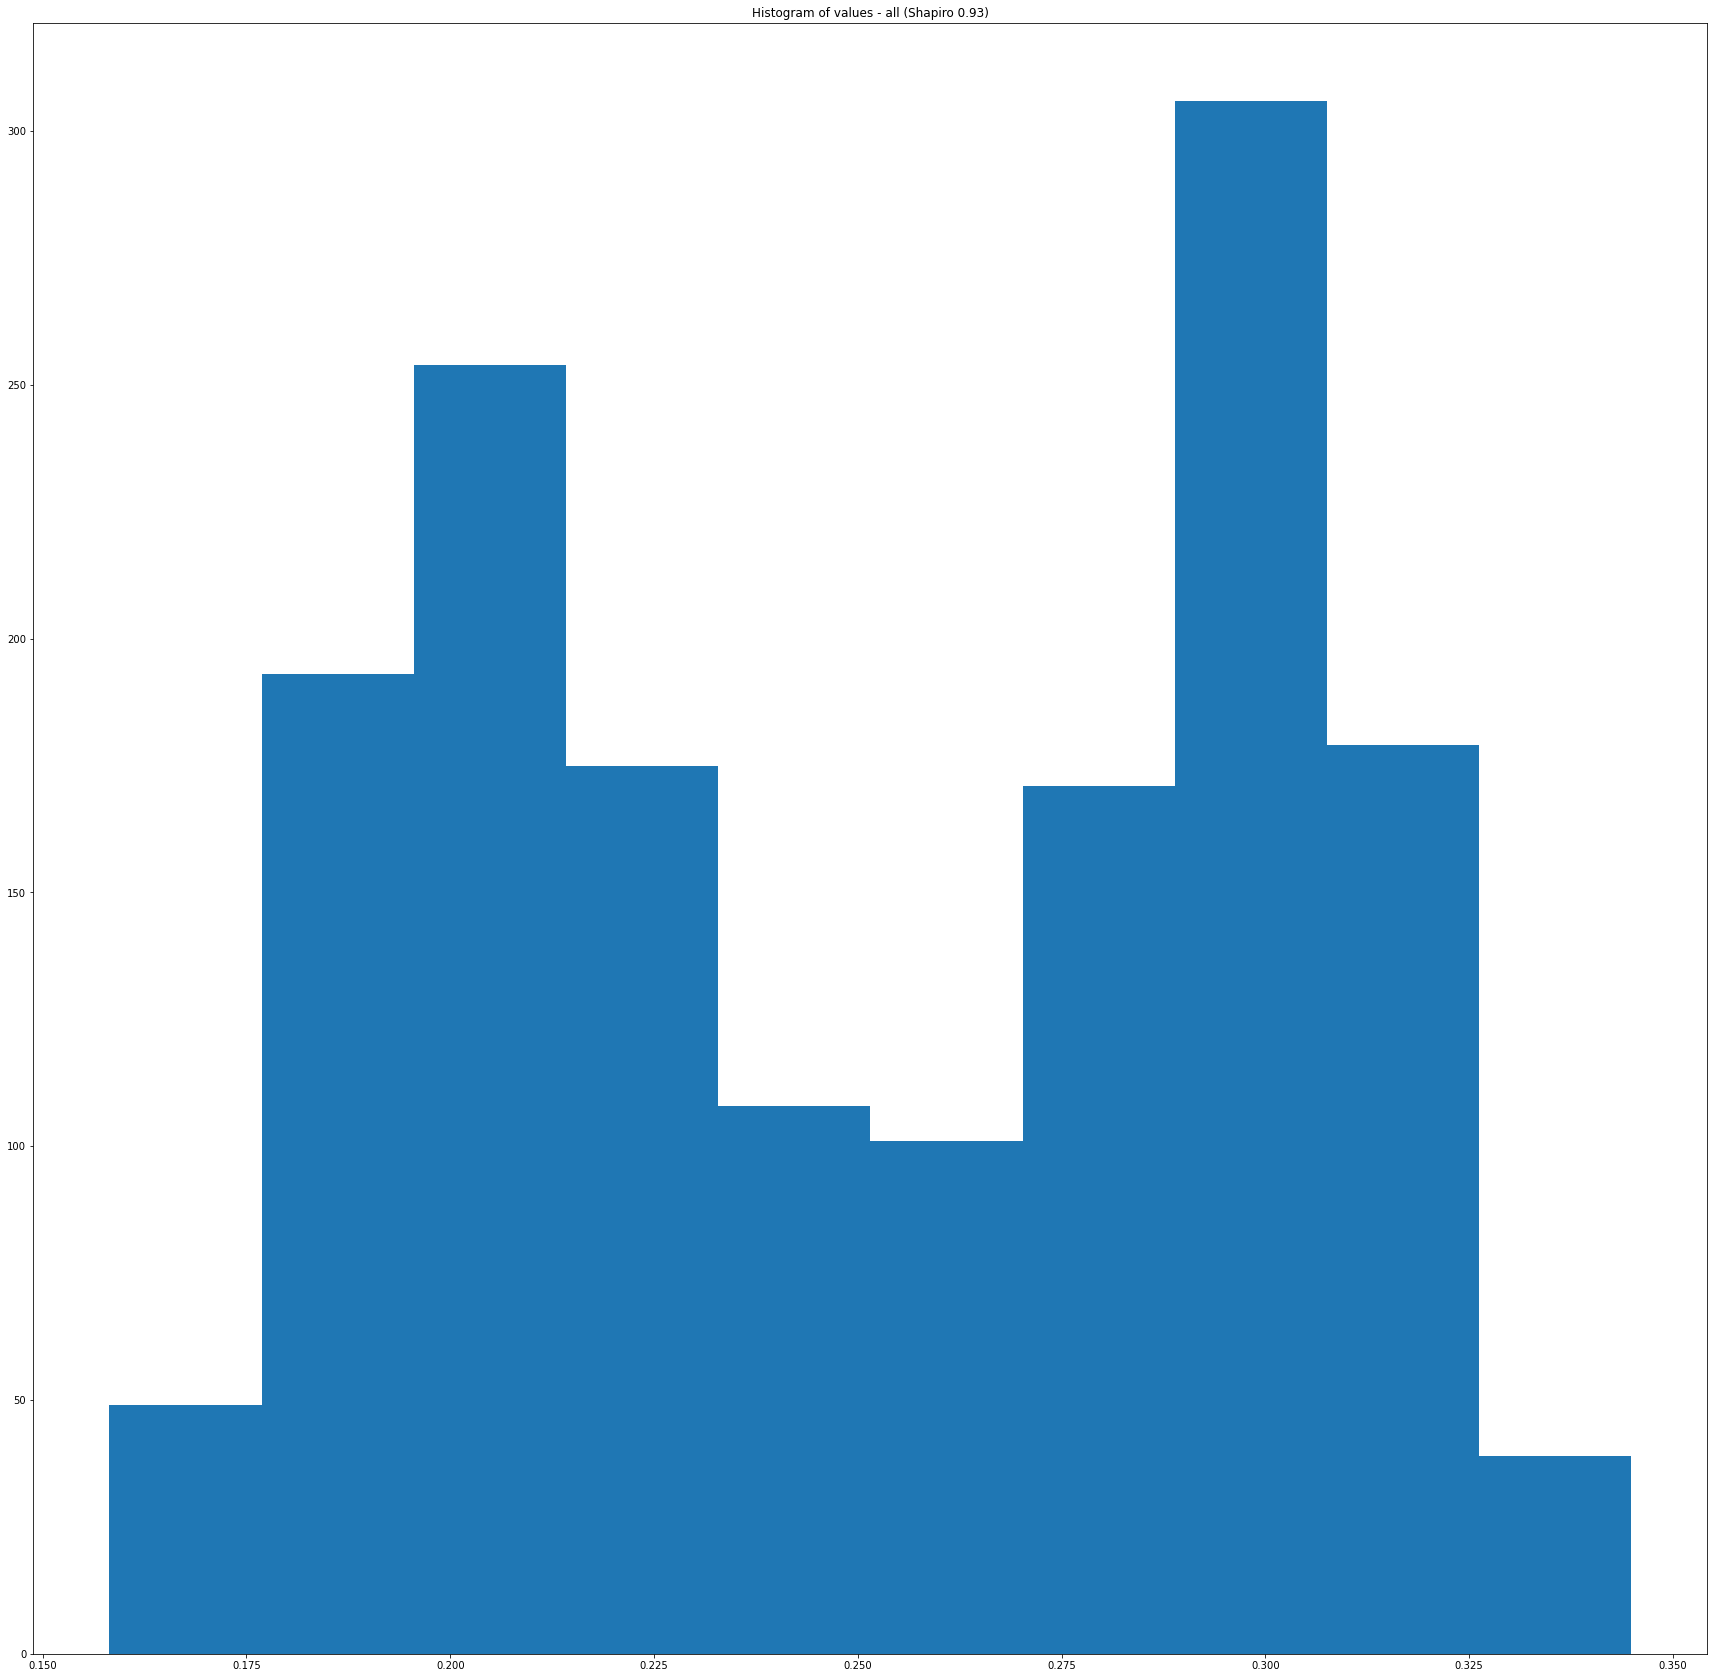

In [68]:
# I need to check normality of p(y|xhat), where xhat are the areas?
from scipy import stats
#shapiro_test = stats.shapiro(x)
#shapiro_test
# 45 subjects
# p_y_x_hat.shape
clus_areas = ib_data.clus.copy()
clusters_matrix_areas = ib_data.clusters_matrix.copy()
print(clusters_matrix_areas[100])
print(ib_data.input_matrix.shape)
print(stats.shapiro((ib_data.input_matrix[:,clusters_matrix_areas[100]<=6])))
# stats.shapiro(input_matrix[1,clusters_matrix_subjects[400]==3])
plt.hist((np.matrix.flatten(ib_data.input_matrix[:,clusters_matrix_areas[100]<=6])))
plt.title('Histogram of values - all (Shapiro 0.93)')
for i in range(len(clusters_matrix_areas[100])):
    if clusters_matrix_areas[100][i] == 6:
        print(i, ib_data.area_names[i])
# list(clusters_matrix_areas[500]==0)]
# plt.savefig('D:\\ELSC\\Aviv\\Tali\\right_norm\\x\\all.png')